In [6]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
filt_1_seq_df = pd.read_csv('../data/interim/pd_filt_1_seqs.csv')
filt_1_hhblits_df = pd.read_csv('../data/interim/pd_filt_1_msas_self_hhblits_results.csv')
prefilt_protein_operons = pd.read_csv('../data/interim/prefilt_pd_prediction_df.csv')
easy_filt_novel_def_proteins = pd.read_csv('../data/interim/easy_filt_novel_def_proteins.csv')

In [8]:
filt_1_hhblits_df['target'] = filt_1_hhblits_df['hit_name'].str.split('.', expand=True)[0]
filt_1_hhblits_df['q_ali_len'] = filt_1_hhblits_df['qend'] - filt_1_hhblits_df['qstart']

In [9]:
prob_cutoff = 50
cov_cutoff = 0.8

In [10]:
merged_hhblits_df = (filt_1_hhblits_df.merge(filt_1_seq_df, how='inner', on='query'))
merged_hhblits_df['qcov'] = merged_hhblits_df['q_ali_len']/merged_hhblits_df['seq_len']
filtered_hhblits_df = (merged_hhblits_df.query('query != target')
                       .query('qcov > ' + str(cov_cutoff))
                       .query('Prob > ' + str(prob_cutoff)))
len(filtered_hhblits_df)

272

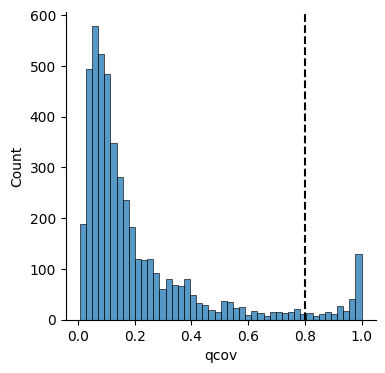

In [11]:
plt.subplots(figsize=(4,4))
sns.histplot(merged_hhblits_df.loc[merged_hhblits_df['query'] != merged_hhblits_df['target'], 
                                   'qcov'])
sns.despine()
plt.axvline(x=cov_cutoff, linestyle='dashed', color='black')

In [12]:
G = nx.from_pandas_edgelist(filtered_hhblits_df, source='query', target='target')
print('nodes', G.number_of_nodes())
print('edges', G.number_of_edges())
node_list = list(G.nodes)
for acc in filt_1_seq_df['query']:
    if acc not in node_list:
        G.add_node(acc)
components = nx.connected_components(G)
component_list = []
for component, accs in enumerate(components):
    for acc in accs:
        component_list.append({'query': acc, 
                               'component': component})
component_df = pd.DataFrame(component_list)
print('n_components', component + 1)
component_df['component'].value_counts().head(10)

nodes 174
edges 168
n_components 362


component
2     13
35     6
21     5
3      5
33     5
4      4
44     4
36     4
30     4
53     4
Name: count, dtype: int64

In [18]:
component_df.loc[component_df['query'].isin(easy_filt_novel_def_proteins['product_accession'].str.split('.', expand=True)[0]), 
                 'component'].nunique()

354

In [14]:
prefilt_protein_operons['query'] = prefilt_protein_operons['product_accession'].str.split('.', expand=True)[0]
ref_df = (prefilt_protein_operons.merge(component_df, how='inner', on='query')
                                       .sort_values(['cloned', 'beaker_prediction'], ascending=False))
#decreasing_df = component_merged_filt_1_predictions.copy()
decreasing_df = ref_df.copy()

In [15]:
minimal_pd_operon_list = []
while len(decreasing_df):
    top_row = decreasing_df.head(1).squeeze()
    top_operon = top_row['operon']
    operon_components = ref_df.loc[ref_df['operon'] == top_operon, 'component'].to_list()
    decreasing_df = decreasing_df[~decreasing_df['component'].isin(operon_components)]
    operon_df = prefilt_protein_operons[prefilt_protein_operons['operon'] == top_operon]
    minimal_pd_operon_list.append(operon_df)
    

In [16]:
minimal_pd_operon_df = (pd.concat(minimal_pd_operon_list)
                        .reset_index(drop=True)
                        .merge(component_df, how='left', on='query'))
print('Unique operons:', minimal_pd_operon_df['operon'].nunique())
print('Unique cloned operons:', minimal_pd_operon_df.loc[minimal_pd_operon_df['cloned'], 
                                                        'operon'].nunique())
print('Unique proteins:', minimal_pd_operon_df['product_accession'].nunique())

Unique operons: 330
Unique cloned operons: 53
Unique proteins: 539


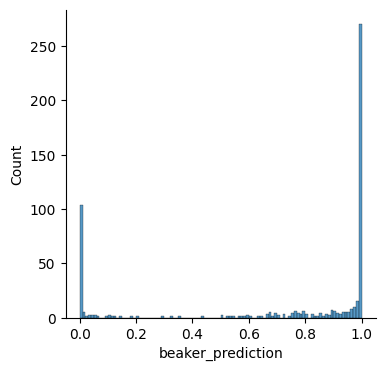

In [73]:
plt.subplots(figsize=(4,4))
sns.histplot(data=minimal_pd_operon_df,
             x='beaker_prediction', binwidth=0.01)
sns.despine()

In [74]:
pd_operon_max_prob = (minimal_pd_operon_df.groupby('operon')
                      .agg(max_p_defense = ('beaker_prediction', 'max'))
                      .reset_index())

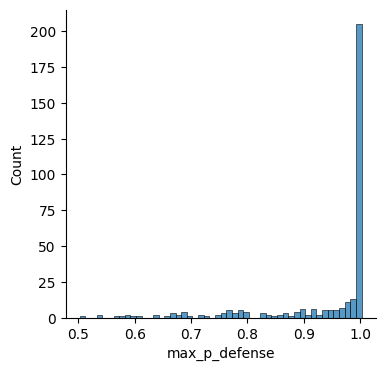

In [75]:
plt.subplots(figsize=(4,4))
sns.histplot(data=pd_operon_max_prob,
             x='max_p_defense', binwidth=0.01)
sns.despine()

In [78]:
minimal_pd_operon_df.columns

Index(['protein_context_id', 'beaker_prediction', '# feature', 'class',
       'assembly', 'assembly_unit', 'seq_type', 'chromosome',
       'genomic_accession', 'start', 'end', 'strand', 'product_accession',
       'non-redundant_refseq', 'related_accession', 'name', 'symbol', 'GeneID',
       'locus_tag', 'feature_interval_length', 'product_length', 'attributes',
       'assembly_stub', 'protein_assembly', 'defense_homolog',
       'defense_system_protein', 'operon', 'contig_end', 'cluster_id',
       'MG1655_homolog', 'cloned', 'query', 'component'],
      dtype='object')

In [80]:
minimal_pd_operon_df['name'].value_counts().head(10)

name
hypothetical protein                   319
AAA family ATPase                        8
restriction endonuclease                 4
ATP-binding protein                      4
type IA DNA topoisomerase                4
tyrosine-type recombinase/integrase      3
H-NS histone family protein              3
phage repressor protein CI               3
SNF2-related protein                     3
integrase domain-containing protein      3
Name: count, dtype: int64

In [81]:
minimal_pd_operon_df.to_csv('../data/interim/ecor_minimal_pd_operons.csv', index=False)